<a href="https://colab.research.google.com/github/balados85/deep-learning-brain-mri-classification/blob/main/RandomSearchCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install keras-tuner -q

In [10]:
from google.colab import drive
from tensorflow import keras
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from glob import glob
from keras_tuner import HyperModel
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale = 1./255)

train_set = train_datagen.flow_from_directory('drive/MyDrive/mri_keras_images/train',
                                            target_size = (224, 224),
                                            batch_size = 32)

validation_set = train_datagen.flow_from_directory('drive/MyDrive/mri_keras_images/validation',
                                            target_size = (224, 224),
                                            batch_size = 32)

Found 1746 images belonging to 3 classes.
Found 806 images belonging to 3 classes.


In [12]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [13]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('drive/MyDrive/mri_keras_images/test',
                                            target_size = (224, 224),
                                            batch_size = 32)

Found 569 images belonging to 3 classes.


In [14]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

**Setting up the tuner**

In [15]:
class MyHyperModel(HyperModel):
    def __init__(self, classes):
        self.classes = classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[224, 224, 3]))
        model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

        model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
        model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

        model.add(tf.keras.layers.Dropout(0.25))

        model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
        model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

        model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
        model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

        model.add(tf.keras.layers.Dropout(0.25))

        model.add(layers.Flatten())

        model.add(
            layers.Dense(
                units=hp.Int("units", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )

        model.add(tf.keras.layers.Dropout(0.5))

        model.add(layers.Dense(self.classes, activation="softmax"))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
            ),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model


hypermodel = MyHyperModel(classes=3)



In [16]:
tuner = RandomSearch(
    hypermodel,
    objective="val_accuracy",
    max_trials=3,
    overwrite=True,
    directory="my_dir",
    project_name="MRI image classification",
)

In [ ]:
x = img_augmentation(train_set)
x = preprocess_input(x)
tuner.search(x, epochs=2, validation_data=(validation_set))

Consider rewriting this model with the Functional API.


In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} which gave a validation accuracy of .
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 320 and the optimal learning rate for the optimizer
is 0.0001 which gave a validation accuracy of .



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

In [ ]:
history = model.fit(train_set, epochs=50, validation_data = validation_set)

Epoch 1/50
55/55 [==============================] - 134s 2s/step - loss: 1.0218 - accuracy: 0.4954 - val_loss: 0.7155 - val_accuracy: 0.7432
Epoch 2/50
55/55 [==============================] - 133s 2s/step - loss: 0.7384 - accuracy: 0.6730 - val_loss: 0.3960 - val_accuracy: 0.8486
Epoch 3/50
55/55 [==============================] - 132s 2s/step - loss: 0.5268 - accuracy: 0.7927 - val_loss: 0.2471 - val_accuracy: 0.9541
Epoch 4/50
55/55 [==============================] - 132s 2s/step - loss: 0.4116 - accuracy: 0.8333 - val_loss: 0.2344 - val_accuracy: 0.9429
Epoch 5/50
55/55 [==============================] - 132s 2s/step - loss: 0.3341 - accuracy: 0.8666 - val_loss: 0.2116 - val_accuracy: 0.9429
Epoch 6/50
55/55 [==============================] - 133s 2s/step - loss: 0.2728 - accuracy: 0.8952 - val_loss: 0.1761 - val_accuracy: 0.9491
Epoch 7/50
55/55 [==============================] - 133s 2s/step - loss: 0.2348 - accuracy: 0.9078 - val_loss: 0.1733 - val_accuracy: 0.9467
Epoch 8/50
55

In [ ]:
val_acc_per_epoch = history.history['val_accuracy']

In [ ]:
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 23


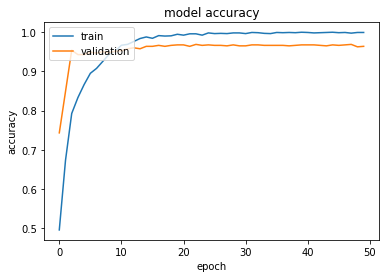

In [ ]:
plot_hist(history)

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hist = hypermodel.fit(train_set, epochs=best_epoch, validation_data=validation_set)


eval_result = hypermodel.evaluate(test_set)
print("[test loss, test accuracy]:", eval_result)

Epoch 1/23
55/55 [==============================] - 134s 2s/step - loss: 1.0576 - accuracy: 0.4496 - val_loss: 0.8291 - val_accuracy: 0.7122
Epoch 2/23
55/55 [==============================] - 132s 2s/step - loss: 0.8478 - accuracy: 0.5916 - val_loss: 0.4826 - val_accuracy: 0.9467
Epoch 3/23
55/55 [==============================] - 133s 2s/step - loss: 0.5548 - accuracy: 0.7698 - val_loss: 0.3019 - val_accuracy: 0.9330
Epoch 4/23
55/55 [==============================] - 132s 2s/step - loss: 0.4079 - accuracy: 0.8276 - val_loss: 0.2684 - val_accuracy: 0.9280
Epoch 5/23
55/55 [==============================] - 133s 2s/step - loss: 0.3491 - accuracy: 0.8477 - val_loss: 0.2666 - val_accuracy: 0.9243
Epoch 6/23
55/55 [==============================] - 132s 2s/step - loss: 0.2875 - accuracy: 0.8797 - val_loss: 0.2901 - val_accuracy: 0.9156
Epoch 7/23
55/55 [==============================] - 133s 2s/step - loss: 0.2318 - accuracy: 0.9152 - val_loss: 0.2605 - val_accuracy: 0.9256
Epoch 8/23
55

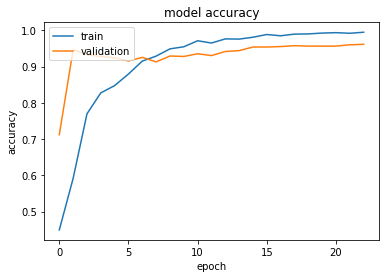

In [ ]:
plot_hist(hist)

In [ ]:
model.summary()
hypermodel.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0

In [ ]:
tuner.results_summary()

Results summary
Results in my_dir/MRI image classification
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 320
learning_rate: 0.0001
Score: 0.9478908181190491
Trial summary
Hyperparameters:
units: 288
learning_rate: 0.0001
Score: 0.7729528546333313
Trial summary
Hyperparameters:
units: 96
learning_rate: 0.0001
Score: 0.6935483813285828
